# Appendix (python code)

# **Machine Learning Model to Predict Disease Status in Retinal Eye Images**

## Pre-processing 

### Import images

In [22]:
import os
path = 'C:/Users/srila/Desktop/AI_ML_CW/eye_images' #set the path to the original images

In [26]:
import os
Normal = os.path.join(path,'1_normal/')
Cataract = os.path.join(path,'2_cataract/')
Glaucoma = os.path.join(path,'2_glaucoma/')

Check the number of images in each directory

In [29]:
print("Number of Normal Images", len(os.listdir(Normal)))
print("Number of Cataract Images", len(os.listdir(Cataract)))
print("Number of Glaucoma Images", len(os.listdir(Glaucoma)))

Number of Normal Images 300
Number of Cataract Images 100
Number of Glaucoma Images 101


### Resize images to 224 by 224 to fit CNN model

In [31]:
#Ensuring all images have the same size
import os
from PIL import Image
import numpy as np

#Store into one variable
eye_images = {
    'Normal' : os.path.join(path,'1_normal/'),
    'Cataract' : os.path.join(path,'2_cataract/'),
    'Glaucoma' : os.path.join(path,'2_glaucoma/')
}

#Create array for the images to be stored into
image_data = {'Normal': [], 'Cataract': [], 'Glaucoma': []} 

#Iterate through each category
for category, input_dir in eye_images.items():
    for filename in os.listdir(input_dir):
        if filename.endswith('.png'):
            img_path = os.path.join(input_dir, filename)
            img = Image.open(img_path)

            #Resize the image to 224x224 pixels
            img_resized = img.resize((224, 224))

            #Convert to NumPy array
            img_array = np.array(img_resized)

            #Append to category list
            image_data[category].append(img_array)

#Convert lists to NumPy arrays
for category in image_data:
    image_data[category] = np.array(image_data[category])

View resized image

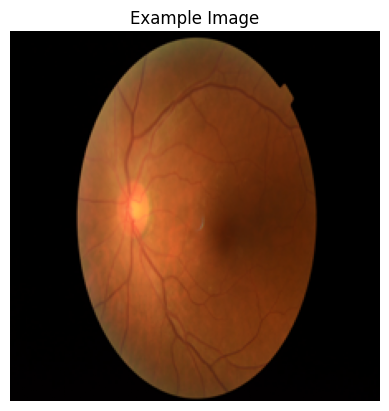

In [ ]:
import matplotlib.pyplot as plt

example_image = image_data['Normal'][230]
#Display the image
plt.imshow(example_image)
plt.axis("off")  
plt.title(f"Example Image")
plt.show()

### Apply Contrast Limited Adaptive Histogram Equalization (CLAHE)

CLAHE increases the contrast of each image for better representation of areas with poor lighting or low contrast

In [ ]:
import os
import cv2 as cv

#Store into one variable
clahe_images = {
    'Normal': 'normal_clahe/',
    'Cataract': 'cataract_clahe/',
    'Glaucoma': 'glaucoma_clahe/'
}

#Iterate over each category
for condition in image_data.keys():
    output_path = os.path.join(path, clahe_images[condition])
    os.makedirs(output_path, exist_ok=True)  #Ensure output directory exists

    for idx, image_array in enumerate(image_data[condition]):
        #Scale only if pixel values are between 0 and 1 as CLAHE requires 0 - 255 range
        if image_array.max() <= 1.0 and image_array.min() >= 0.0:
            image_array = (image_array * 255).astype(np.uint8)

        #Convert to LAB and apply CLAHE
        img2 = cv.cvtColor(image_array, cv.COLOR_RGB2LAB)
        L_channel = img2[:, :, 0] #only adjust the L (light) channel
        claheObj = cv.createCLAHE(clipLimit=5.0, tileGridSize=(8, 8))
        claheL = claheObj.apply(L_channel)
        img2[:, :, 0] = claheL
        claheImgRGB = cv.cvtColor(img2, cv.COLOR_LAB2RGB)

        #Normalise the image (scale to range [0, 1])
        clahe_img_normalised = claheImgRGB.astype(np.float32) / 255.0

        #Save the CLAHE image
        output_file = os.path.join(output_path, f"Image_{idx}.png")
        cv.imwrite(output_file, cv.cvtColor(clahe_img_normalised, cv.COLOR_RGB2BGR))


View CLAHE image

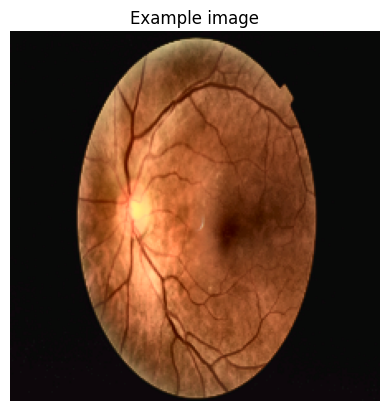

In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt

#Read the image from the normal_clahe directory
image = cv.imread(os.path.join(path,'normal_clahe/', 'Image_230.png'))

#Convert the image from BGR to RGB for matplotlib display
image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

# Display the image
plt.imshow(image_rgb)
plt.title("Example image")
plt.axis('off')  
plt.show()


### Pixel value validation

Ensure all pixels are in the range as expected for a 8-bit image.

Iterate through all classes

In [ ]:
#Store into one variable
input_dir = {
    os.path.join(path,'normal_clahe/'),
    os.path.join(path,'cataract_clahe/'),
    os.path.join(path,'glaucoma_clahe/')
}

#Initialise counters
within_range = 0
out_of_range = 0

for directory in input_dir:
    for filename in os.listdir(directory):
        if filename.endswith(('.png')):  
            img_path = os.path.join(directory, filename)
            image = Image.open(img_path)

            #Convert the image to a NumPy array
            image_array = np.array(image)

            #Compute statistics
            min_val = np.min(image_array)
            max_val = np.max(image_array)

            #Check if normalisation is needed
            if 0 <= min_val <= 1 and 0 <= max_val <= 1:
                within_range += 1
            else:
                out_of_range += 1

print(f"  {within_range} Values within range.")
print(f"  {out_of_range} Values out of expected range.")

  501 Values within range.
  0 Values out of expected range.


### Apply the Enhanced Super-Resolution Generative Adversarial Network (ESRGAN) technique

ESRGAN is an imaging technique that increases the resolution of the images. Since it is a pre-trained model, images were processed through it, and the resulting high-resolution images were saved into subdirectories. 

To use the model, the repository ws cloned from git and was run by running test.py

1. !git clone https://github.com/xinntao/ESRGAN.git

2. !python test.py

View ESRGAN image

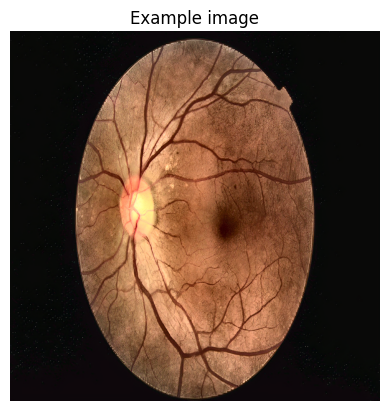

In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt

#Read the image from the normal_esrgan directory
image = cv.imread(os.path.join(path,'1_normal_esrgan/', 'Image_230.png'))

#Convert the image from BGR to RGB for matplotlib display
image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

#Display the image
plt.imshow(image_rgb)
plt.title("Example image")
plt.axis('off')  
plt.show()

These enhanced images were then used as input for training the model below.

## Oversample the minority class

Current classes have class imbalance, where normal images have 300 images, cataract 100 and glaucoma 101. Oversampling increases the number of images by generating synthetic images, making model less biased and more generalisable.

In [3]:
import os
import numpy as np
from PIL import Image
from imblearn.over_sampling import ADASYN

modified_images = {
    'normal_esrgan' : os.path.join(path, '1_normal_esrgan'),
    'cataract_esrgan' : os.path.join(path,'2_cataract_esrgan'),
    'glaucoma_esrgan' : os.path.join(path,'2_glaucoma_esrgan')
}

#Load images and labels
x = []  # Feature vectors
y = []  # Labels

for label, folder in enumerate(modified_images.values()):  #Assign numeric labels to each class
    for filename in os.listdir(folder):
        if filename.endswith('.png'):  
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).resize((224, 224))  #Resize images
            img_array = np.array(img).flatten()  #Flatten the image into a vector
            x.append(img_array)
            y.append(label)

#Convert to NumPy arrays
x = np.array(x)
y = np.array(y)

#Apply ADASYN
ada = ADASYN(random_state=42)
x_res, y_res = ada.fit_resample(x, y)

## Model requirements

### Split the dataset into training, test and validation

In [4]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

#Split into training and temporary sets into 80% and 20%
x_train, x_temp, y_train, y_temp = train_test_split(x_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

#Split the temporary set into validation and test set, 10% each
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

#Reshape the input data to (None, 224, 224, 3) for x_train, x_test, and x_val
x_train = tf.reshape(x_train, (-1, 224, 224, 3))
x_test = tf.reshape(x_test, (-1, 224, 224, 3))
x_val = tf.reshape(x_val, (-1, 224, 224, 3))

Check shapes of labels

In [5]:
print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of y_test:", y_test.shape)

Shape of y_train: (699,)
Shape of y_val: (87,)
Shape of y_test: (88,)


The current shape is for binary classification, however we have 3 classes therefore needs to be in the (699, 3) format

### One-hot encode the labels

In [6]:
import tensorflow
#One-hot encode training set
y_train_cat = tensorflow.keras.utils.to_categorical(y_train, num_classes=3)

#also for the test set
y_test_cat = tensorflow.keras.utils.to_categorical(y_test, num_classes=3)

#and then for val
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=3)

## Create the model

### Import the base model ResNet50

In [6]:
from tensorflow.keras.applications import ResNet50

resnet_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape= (224,224,3)
)

#Initially all layers were set to be non-trainable 
#for layer in resnet_model.layers:
    #layer.trainable = False

#For fine tuning unfreeze the last 10 layers
for layer in resnet_model.layers[-10:]:
    layer.trainable = True

### Create model by adding custom layers on top of ResNet50

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

model = Sequential( [
 resnet_model,
 Flatten(),
 Dense(120, activation='relu'),
 Dropout(0.5),  #Dropout to prevent overfitting
 Dense(64, activation='relu'),
 Dropout(0.5),  #Another Dropout layer
 Dense(3, activation='softmax')  #Set for 3 classes
] )

#View model summary 
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 120)            │    12,042,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         7,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,638,011 (135.95 MB)

 Trainable params: 35,584,891 (135.75 MB)

 Non-trainable params: 53,120 (207.50 KB)

### Compile the model

In [33]:
import tensorflow as tf
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

#categorical_crossentropy set for one hot encoded labels
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) 

### Train the model with augmented training data

Only slight augmentation has been applied 

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=[0.8, 1.2]  # Small brightness variations
)

#Fit the generator on training data
datagen.fit(x_train)  

#Train the model 
history = model.fit(datagen.flow(x_train, y_train_cat, batch_size=32),
          validation_data=(x_val, y_val_cat),
          epochs=30,
          callbacks=[early_stopping])
#Removed epoch output to convert to pdf

In [35]:
epochs = history.epoch

## Model Evaluation

### Plot the training and validation accuracy graph

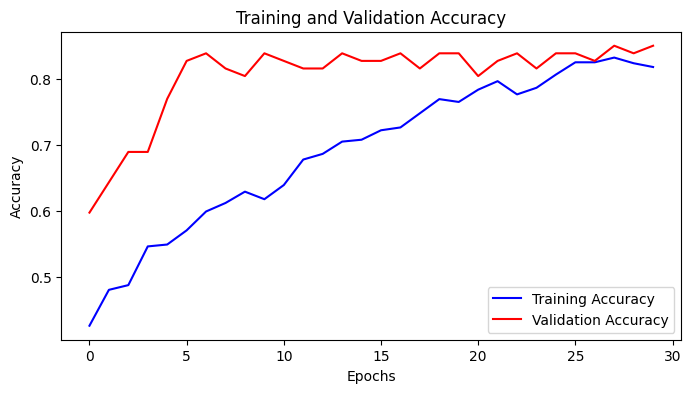

In [36]:
accuracy_values = history.history['accuracy']
val_accuracy_values = history.history['val_accuracy']

plt.figure(figsize=(8, 4))
plt.plot(epochs, accuracy_values, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy_values, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Plot the training and validation loss graph

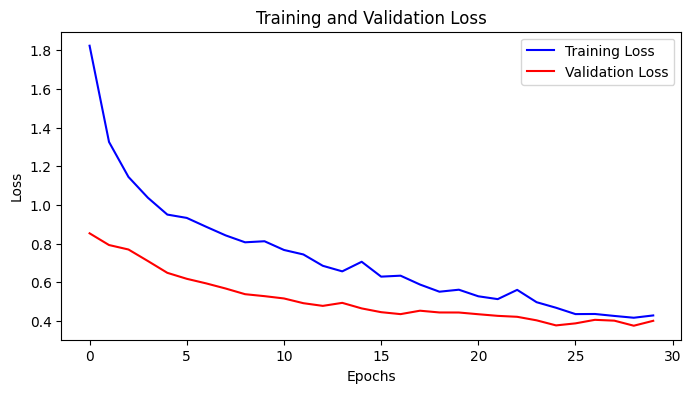

In [37]:
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

plt.figure(figsize=(8, 4))
plt.plot(epochs, loss_values, 'b', label='Training Loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Use the model to make predictions on the test set
y_pred_prob = model.predict(x_test)

# Convert predictions to binary class labels
y_pred  = y_pred_prob.argmax(axis=1)

### Plot the confusion matrix

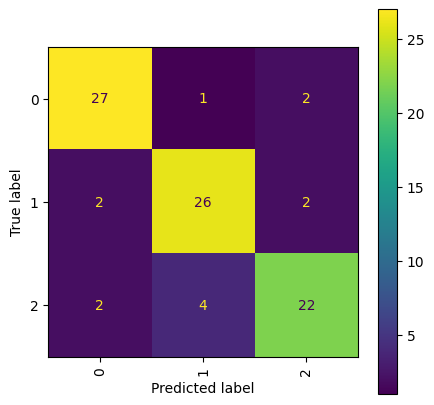

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm  = confusion_matrix(y_test, y_pred)
cmdisp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(5, 5))
cmdisp.plot(include_values=True, cmap="viridis", ax=ax, xticks_rotation="vertical")
plt.show()

### Create the classification report for evaluation

In [40]:
from sklearn.metrics  import classification_report
print('Classification Report:')
print(classification_report(y_test,y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.89        30
           1       0.84      0.87      0.85        30
           2       0.85      0.79      0.81        28

    accuracy                           0.85        88
   macro avg       0.85      0.85      0.85        88
weighted avg       0.85      0.85      0.85        88



### Plot ROC curve

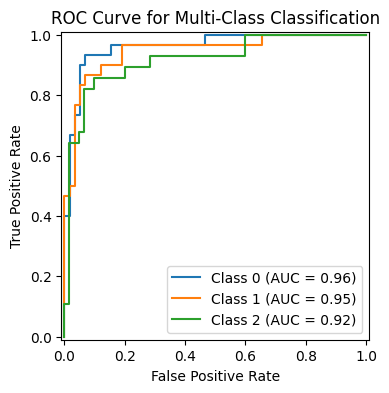

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import label_binarize

def calc_and_plot_roc(y_test, y_pred_prob, figsize=4):
    classes = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=classes)  #Convert labels to one-hot encoding

    #Check if y_pred is in probability format
    if y_pred_prob.ndim == 1 or y_pred_prob.shape[1] != len(classes):
        raise ValueError(f"y_pred_prob must have shape (n_samples, n_classes). Got {y_pred_prob.shape}")

    fig, ax = plt.subplots(figsize=(figsize, figsize))

    for i in range(y_test_bin.shape[1]):  # Loop through each class
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        auc = roc_auc_score(y_test_bin[:, i], y_pred_prob[:, i])
        RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name=f'Class {classes[i]}').plot(ax=ax)

    plt.title("ROC Curve for Multi-Class Classification")
    plt.show()

calc_and_plot_roc(y_test, y_pred_prob)